##Download Data

In [6]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download "dogs-vs-cats"

 96% 261M/271M [00:02<00:00, 123MB/s]
100% 271M/271M [00:02<00:00, 137MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 94.2MB/s]
 98% 533M/543M [00:04<00:00, 102MB/s] 
100% 543M/543M [00:04<00:00, 133MB/s]


##Unzip Data

In [8]:
import zipfile

In [9]:
train_zip = "/content/train.zip"
data_dir = "./data"
train_zip_ref = zipfile.ZipFile(train_zip,"r")
train_zip_ref.extractall(data_dir)

##Create Subdirectories
For both train and validation

In [10]:
import os
import glob

In [11]:
dat_dir = "/content/data"

#create training dir
training_dir = os.path.join(data_dir,"training")
if not os.path.isdir(training_dir):
  os.mkdir(training_dir)

#create dog in training
dog_training_dir = os.path.join(training_dir,"dog")
if not os.path.isdir(dog_training_dir):
  os.mkdir(dog_training_dir)

#create cat in training
cat_training_dir = os.path.join(training_dir,"cat")
if not os.path.isdir(cat_training_dir):
  os.mkdir(cat_training_dir)

#create validation dir
validation_dir = os.path.join(data_dir,"validation")
if not os.path.isdir(validation_dir):
  os.mkdir(validation_dir)

#create dog in validation
dog_validation_dir = os.path.join(validation_dir,"dog")
if not os.path.isdir(dog_validation_dir):
  os.mkdir(dog_validation_dir)

#create cat in validation
cat_validation_dir = os.path.join(validation_dir,"cat")
if not os.path.isdir(cat_validation_dir):
  os.mkdir(cat_validation_dir)

##Split from directory

In [15]:
import shutil

split_size = 0.80
cat_imgs_size = len(glob.glob("/content/data/train/cat*"))
dog_imgs_size = len(glob.glob("/content/data/train/dog*"))

for i,img in enumerate(glob.glob("/content/data/train/cat*")):
  if i < (cat_imgs_size * split_size):
    shutil.move(img,cat_training_dir)
  else:
    shutil.move(img,cat_validation_dir)

for i,img in enumerate(glob.glob("/content/data/train/dog*")):
  if i < (dog_imgs_size * split_size):
    shutil.move(img,dog_training_dir)
  else:
    shutil.move(img,dog_validation_dir)

##Plot some examples

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

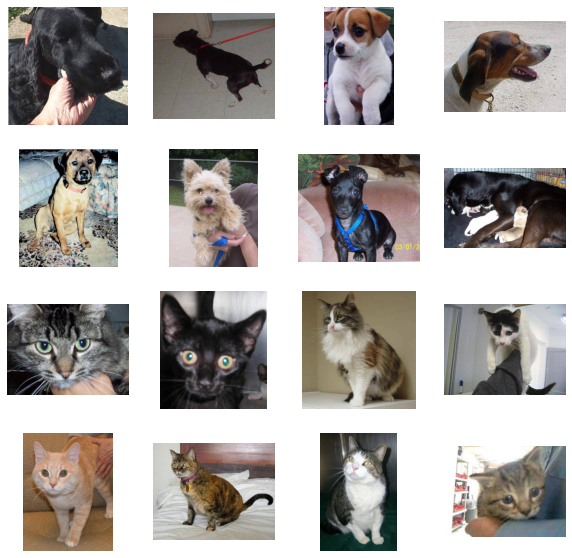

In [17]:
from IPython.core.pylabtools import figsize

samples_dog = [os.path.join(dog_training_dir,np.random.choice(os.listdir(dog_training_dir),1)[0]) for _ in range(8)]
samples_cat = [os.path.join(cat_training_dir,np.random.choice(os.listdir(cat_training_dir),1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(samples_dog[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
  else:
    pic = plt.imread(samples_cat[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
plt.show()

##Build the model

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential

In [75]:
model = Sequential([
  Conv2D(filters = 32, kernel_size= (3,3), strides = (1,1), activation = "relu", input_shape = (150,150,3)),
  MaxPooling2D(pool_size = (2,2)),

  Conv2D(filters = 64, kernel_size= (3,3), strides = (1,1), activation = "relu"),
  MaxPooling2D(pool_size = (2,2)),

  Conv2D(filters = 128, kernel_size= (3,3), strides = (1,1), activation = "relu"),
  MaxPooling2D(pool_size = (2,2)),

  Conv2D(filters = 128, kernel_size= (3,3), strides = (1,1), activation = "relu"),
  MaxPooling2D(pool_size = (2,2)),

  Flatten(),
  Dense(511,activation = "relu"),
  Dense(1, activation = "sigmoid")
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

In [76]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(1e-4), loss = "mse", metrics = ["accuracy"])

##Data Preprocessing

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
BATCH_SIZE = 64
TARGET_SIZE = (150,150)

In [23]:
train_datagen = ImageDataGenerator(rescale = 1/255.)
val_datagen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir,"training"),
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    color_mode = "rgb",
    shuffle = True,
    target_size = TARGET_SIZE
)


val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir,"validation"),
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    color_mode = "rgb",
    shuffle = True,
    target_size = TARGET_SIZE
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [24]:
train_steps = len(glob.glob("/content/data/training/*/*")) // BATCH_SIZE
val_steps = len(glob.glob("/content/data/validation/*/*")) // BATCH_SIZE

history = model.fit(
  train_generator,
  epochs = 8,
  steps_per_epoch = train_steps,
  validation_data= val_generator,
  validation_steps= val_steps
  )

Epoch 1/8
312/312 [==============================] - 101s 284ms/step - loss: 0.2179 - accuracy: 0.6392 - val_loss: 0.1895 - val_accuracy: 0.7073
Epoch 2/8
312/312 [==============================] - 85s 274ms/step - loss: 0.1778 - accuracy: 0.7313 - val_loss: 0.1602 - val_accuracy: 0.7688
Epoch 3/8
312/312 [==============================] - 86s 275ms/step - loss: 0.1568 - accuracy: 0.7727 - val_loss: 0.1427 - val_accuracy: 0.7933
Epoch 4/8
312/312 [==============================] - 87s 279ms/step - loss: 0.1437 - accuracy: 0.7950 - val_loss: 0.1418 - val_accuracy: 0.7987
Epoch 5/8
312/312 [==============================] - 86s 276ms/step - loss: 0.1330 - accuracy: 0.8135 - val_loss: 0.1260 - val_accuracy: 0.8243
Epoch 6/8
312/312 [==============================] - 90s 287ms/step - loss: 0.1243 - accuracy: 0.8265 - val_loss: 0.1274 - val_accuracy: 0.8153
Epoch 7/8
312/312 [==============================] - 92s 294ms/step - loss: 0.1178 - accuracy: 0.8358 - val_loss: 0.1132 - val_accuracy

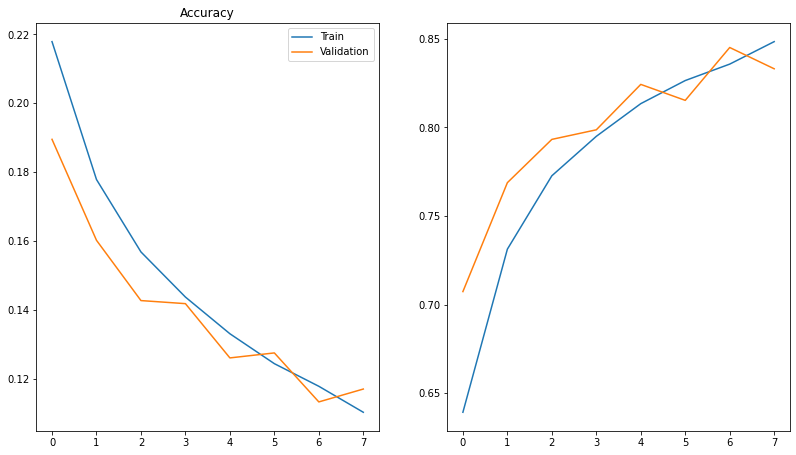

In [59]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(13.5, 7.5)

ax[0].plot(history.history["loss"])
ax[0].plot(history.history["val_loss"])
ax[0].set(title = "Loss")
ax[0].legend(["train","validation"])

ax[1].plot(history.history["accuracy"])
ax[1].plot(history.history["val_accuracy"])
ax[0].set(title = "Accuracy")
ax[0].legend(["Train","Validation"])
plt.show()

#Data Augmentation

##Let's start with a Baseline
We are going to use only 2.000 images for train and 500 for validation.

If we use 20 epochs, and steps = 100, we have in total 2.000 images

In [70]:
BATCH_SIZE = 20

train_base_datagen = ImageDataGenerator(rescale = 1/255.)
train_base_generator = train_base_datagen.flow_from_directory(
    directory = os.path.join(data_dir,"training"),
    batch_size= BATCH_SIZE,
    class_mode = "binary",
    shuffle= True,
    target_size= (150,150),
    color_mode = "rgb",

) 


val_base_datagen = ImageDataGenerator(rescale = 1/255.)
val_base_generator = val_base_datagen.flow_from_directory(
    directory = os.path.join(data_dir,"validation"),
    batch_size= BATCH_SIZE,
    class_mode = "binary",
    shuffle= True,
    target_size= (150,150),
    color_mode = "rgb",

) 

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [71]:
history = model.fit(
  train_base_generator,
  epochs = 10,
  steps_per_epoch = 100,
  validation_data= val_base_generator,
  validation_steps= 100
  )

Epoch 1/10
100/100 [==============================] - 16s 149ms/step - loss: 0.2496 - accuracy: 0.5190 - val_loss: 0.2432 - val_accuracy: 0.5580
Epoch 2/10
100/100 [==============================] - 16s 162ms/step - loss: 0.2394 - accuracy: 0.5820 - val_loss: 0.2358 - val_accuracy: 0.5755
Epoch 3/10
100/100 [==============================] - 15s 149ms/step - loss: 0.2257 - accuracy: 0.6190 - val_loss: 0.2089 - val_accuracy: 0.6945
Epoch 4/10
100/100 [==============================] - 15s 147ms/step - loss: 0.2117 - accuracy: 0.6675 - val_loss: 0.1966 - val_accuracy: 0.7165
Epoch 5/10
100/100 [==============================] - 15s 149ms/step - loss: 0.2031 - accuracy: 0.6900 - val_loss: 0.1977 - val_accuracy: 0.6975
Epoch 6/10
100/100 [==============================] - 15s 153ms/step - loss: 0.1979 - accuracy: 0.6905 - val_loss: 0.1955 - val_accuracy: 0.6835
Epoch 7/10
100/100 [==============================] - 14s 144ms/step - loss: 0.1880 - accuracy: 0.7170 - val_loss: 0.1810 - val_ac

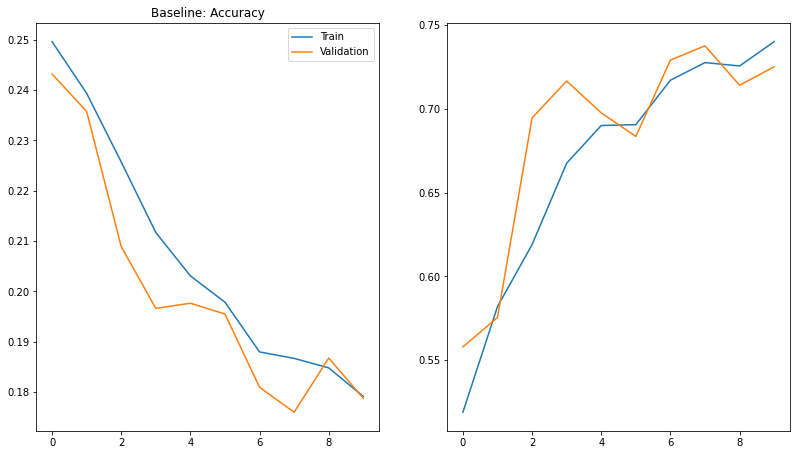

In [72]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(13.5, 7.5)

ax[0].plot(history.history["loss"])
ax[0].plot(history.history["val_loss"])
ax[0].set(title = "Baseline : Loss")
ax[0].legend(["train","validation"])

ax[1].plot(history.history["accuracy"])
ax[1].plot(history.history["val_accuracy"])
ax[0].set(title = "Baseline: Accuracy")
ax[0].legend(["Train","Validation"])
plt.show()

###Lets use data augmentation

In [77]:
BATCH_SIZE = 20

train_aug_datagen = ImageDataGenerator(
    rescale = 1/255.,
    fill_mode="nearest",
    height_shift_range=0.20,
    width_shift_range=0.20,
    horizontal_flip=True,
    rotation_range=45,
    shear_range=0.20,
    zoom_range=0.20,
  )

train_aug_generator = train_aug_datagen.flow_from_directory(
    directory = os.path.join(data_dir,"training"),
    batch_size= BATCH_SIZE,
    class_mode = "binary",
    shuffle= True,
    target_size= (150,150),
    color_mode = "rgb",

) 


val_aug_datagen = ImageDataGenerator(rescale = 1/255.)

val_aug_generator = val_aug_datagen.flow_from_directory(
    directory = os.path.join(data_dir,"validation"),
    batch_size= BATCH_SIZE,
    class_mode = "binary",
    shuffle= True,
    target_size= (150,150),
    color_mode = "rgb",
) 

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [78]:
history = model.fit(
  train_aug_generator,
  epochs = 10,
  steps_per_epoch = 100,
  validation_data= val_aug_generator,
  validation_steps= 100
  )

Epoch 1/10
100/100 [==============================] - 26s 251ms/step - loss: 0.2483 - accuracy: 0.5390 - val_loss: 0.2430 - val_accuracy: 0.5230
Epoch 2/10
100/100 [==============================] - 25s 246ms/step - loss: 0.2424 - accuracy: 0.5675 - val_loss: 0.2456 - val_accuracy: 0.5365
Epoch 3/10
100/100 [==============================] - 24s 244ms/step - loss: 0.2378 - accuracy: 0.5815 - val_loss: 0.2349 - val_accuracy: 0.5755
Epoch 4/10
100/100 [==============================] - 24s 243ms/step - loss: 0.2269 - accuracy: 0.6240 - val_loss: 0.2347 - val_accuracy: 0.5940
Epoch 5/10
100/100 [==============================] - 28s 286ms/step - loss: 0.2285 - accuracy: 0.6175 - val_loss: 0.2124 - val_accuracy: 0.6620
Epoch 6/10
100/100 [==============================] - 24s 243ms/step - loss: 0.2223 - accuracy: 0.6225 - val_loss: 0.2066 - val_accuracy: 0.6895
Epoch 7/10
100/100 [==============================] - 25s 246ms/step - loss: 0.2125 - accuracy: 0.6560 - val_loss: 0.1993 - val_ac

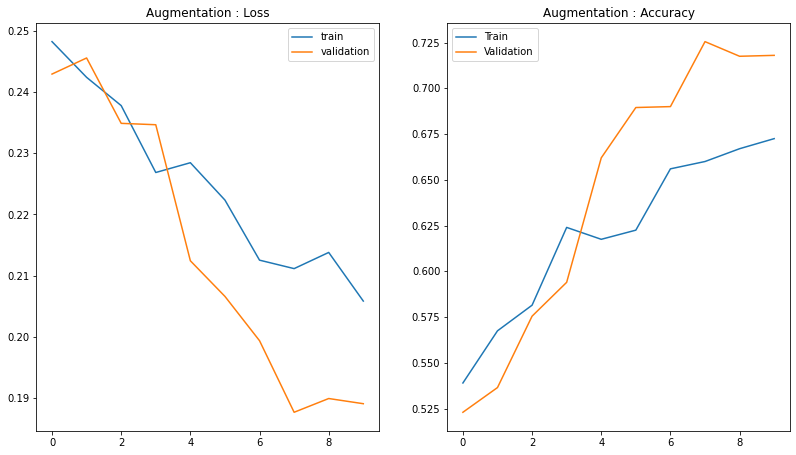

In [80]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(13.5, 7.5)

ax[0].plot(history.history["loss"])
ax[0].plot(history.history["val_loss"])
ax[0].set(title = "Augmentation : Loss")
ax[0].legend(["train","validation"])

ax[1].plot(history.history["accuracy"])
ax[1].plot(history.history["val_accuracy"])
ax[1].set(title = "Augmentation : Accuracy")
ax[1].legend(["Train","Validation"])
plt.show()